# Determinants of trade unit values
- _International Merchandise Trade Statistics (IMTS) often hasve missing and/or outlier quantity information. How can we estimate these quantities?_

- _The notebook will explore variables in IMTS data as well as external variables to determine their suitability as predictors of trade quantities._

In [0]:
#Import required libraries
import pandas as pd
import numpy as np

#import matplotlib.pyplot as plt
#import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.cluster import KMeans

In [0]:
# Set up plotting environment

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Setting plot appearance
%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['axes.labelpad'] = 6
sns.set_style("darkgrid")

## Set parameters for example data
- In the following cell, specify which **commodity, trade flow and years** to use.
- Also, specify if **net weight** (netWgt) or **quantity** (qty) should be used to calculate unit values.

In [0]:
#Specify file path, commodity, flow, whether to use netweight or quantity for unit values
#filepath = 'rice_import_all_rep_all_part.csv'
hs = 100630 #rice
#hs = 870323 #cars (1500-3000cc)
#hs = 260111 #iron ore
#hs = 420221 #handbags
flow = 'M'
#per = 
unit = 'netWgt'
#unit = 'qty'

In [0]:
#Extract data and convert to a pandas dataframe
df_main = sqlContext.sql("select reporterCode, partnerCode, partner2Code, period, cmdCode, cifValue, fobValue, primaryValue, netWgt, qtyUnitCode, qty, customsCode, motCode from delta.dtarifflineannual where flowCategory = 'M' and cmdCode like '100630%' and period BETWEEN 2013 AND 2017")

#df_main = sqlContext.sql("select reporterCode, partnerCode, partner2Code, period, cmdCode, cifValue, fobValue, primaryValue, netWgt, qtyUnitCode, qty, customsCode, motCode from delta.dtarifflineannual where flowCategory = 'M' and cmdCode like '870323%' and period BETWEEN 2013 AND 2017")

#df_main = sqlContext.sql("select reporterCode, partnerCode, partner2Code, period, cmdCode, cifValue, fobValue, primaryValue, netWgt, qtyUnitCode, qty, customsCode, motCode from delta.dtarifflineannual where flowCategory = 'M' and cmdCode like '260111%' and period BETWEEN 2013 AND 2017")

#df_main = sqlContext.sql("select reporterCode, partnerCode, partner2Code, period, cmdCode, cifValue, fobValue, primaryValue, netWgt, qtyUnitCode, qty, customsCode, motCode from delta.dtarifflineannual where flowCategory = 'M' and cmdCode like '420221%' and period BETWEEN 2013 AND 2017")

df_orig = df_main.toPandas()
#df_orig = pd.read_csv(filepath)
df_orig.head()

Out[4]:

reporterCode 
 partnerCode 
 partner2Code 
 period 
 cmdCode 
 cifValue 
 fobValue 
 primaryValue 
 netWgt 
 qtyUnitCode 
 qty 
 customsCode 
 motCode 
 
 
 
 
 0 
 470 
 699 
 -1 
 2016 
 10063021 
 44203.106847 
 44203.106847 
 44203.106847 
 41000.00 
 8 
 41000.00 
 -1 
 -1 
 
 
 1 
 470 
 699 
 -1 
 2016 
 10063025 
 28263.020528 
 28263.020528 
 28263.020528 
 21000.00 
 8 
 21000.00 
 -1 
 -1 
 
 
 2 
 470 
 699 
 -1 
 2016 
 10063061 
 24274.395103 
 24274.395103 
 24274.395103 
 20000.00 
 8 
 20000.00 
 -1 
 -1 
 
 
 3 
 470 
 699 
 -1 
 2016 
 10063065 
 20845.751840 
 20845.751840 
 20845.751840 
 31006.72 
 8 
 31006.72 
 -1 
 -1 
 
 
 4 
 470 
 699 
 -1 
 2016 
 10063067 
 202.924229 
 202.924229 
 202.924229 
 47.00 
 8 
 47.00 
 -1 
 -1

## Removing missing and outliers quantities
- We will remove outliers and missing quantities. Outliers are removed so that these do not affect the analyses.
- To remove outliers, **Tukey's boxplot** method will be used where any values falling outside **[Q1 - 1.5*(Q3-Q1)] and [Q3 + 1.5*(Q3-Q1)]** are considered outliers. These maximum and minimum value ranges for each commidity are available from UN Comtrade.

There are 128675 rows in total
9112 rows were null (7.08% of records)

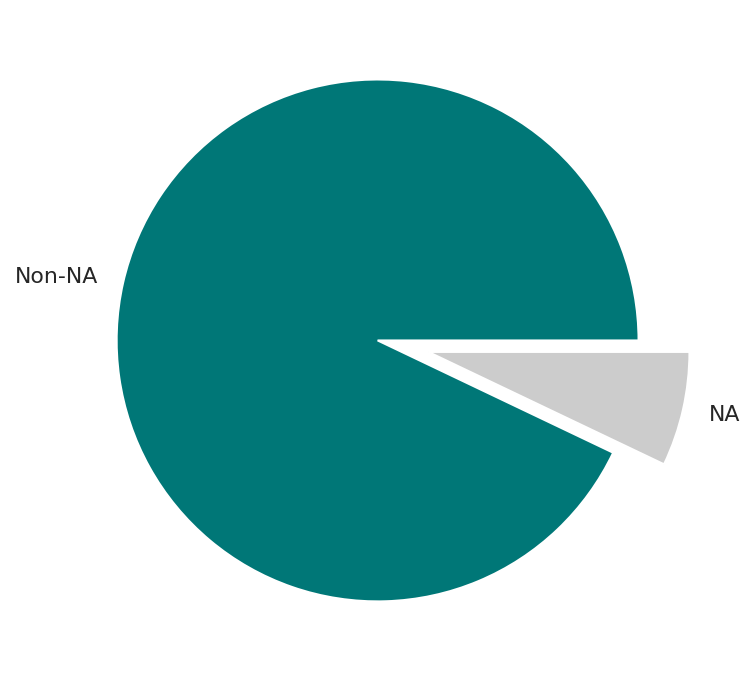

In [0]:
#Drop rows with netweight NA
df = df_orig.dropna(subset=[unit])
df = df[df[unit]!=0]
df['unitValue'] = df['primaryValue']/df[unit]

#Get how many netweight/quantity was null
ro_tot = df_orig.shape[0]
ro_null = df_orig[unit].isnull().sum()
ro_nonull = ro_tot-ro_null
print('There are '+ str(ro_tot)+' rows in total\n'
      +str(ro_null)+' rows were null ('+ str(round(100*ro_null/ro_tot,2))+'% of records)')

#Pie-chart on number of NA records
y = np.array([ro_nonull, ro_null])
mylabels = ["Non-NA", "NA",]
myexplode = [0, 0.2] #this brings out the null pie
mycolors = ["#007777", "#cccccc"]

plt.pie(y, labels = mylabels, explode = myexplode, colors = mycolors)
plt.show() 

In [0]:
period_freq = df.groupby(['period']).size().to_frame(name = 'freq').reset_index()

display(period_freq)

period freq 2013 22009 2014 21075 2015 24932 2016 24757 2017 23060

There are 16665 outlier records in total (12.95% of records)

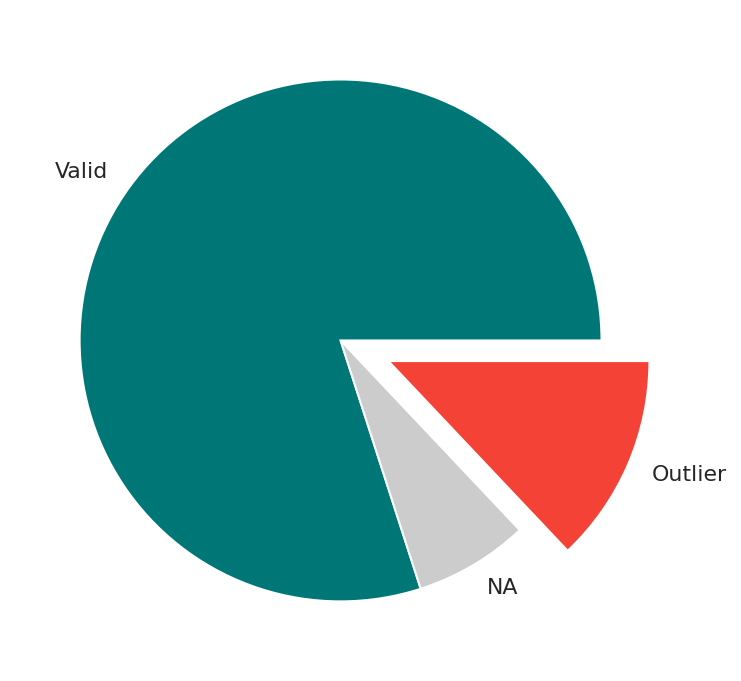

In [0]:
#Load SUV, Min UV and Max UV table uploaded to FileStore from "https://unstats.un.org/unsd/trade/data/tables.asp#SUV"
#NOTE: the file was ANSI encoded which pandas/databricks couldn't read so it was converted to utf-8 in windows
minUV = pd.read_csv("/dbfs/FileStore/tables/TUVMin.txt", sep="\t")
maxUV = pd.read_csv("/dbfs/FileStore/tables/TUVMax.txt", sep="\t")
SUV = pd.read_csv("/dbfs/FileStore/tables/TSUV_tabDelimUtf.txt", sep="\t")

#minUV = pd.read_csv("TUVMin.txt", sep="\t")
#maxUV = pd.read_csv("TUVMax.txt", sep="\t")
#SUV = pd.read_csv("TSUV_tabDelimUtf.txt", sep="\t")

#commodities are quantified either in kg or units (e.g., rice vs cars)
if unit == 'netWgt':
  valType = '$/kg'
else:
  valType = '$/u'

#subset to keep only specified flow and commodity
minUV = minUV[(minUV.trade_flow==flow) & (minUV.commodity_group_code==hs) & (minUV.value_type==valType)]
maxUV = maxUV[(maxUV.trade_flow==flow) & (maxUV.commodity_group_code==hs) & (maxUV.value_type==valType)]
SUV = SUV[(SUV.trade_flow==flow) & (SUV.commodity_group_code==hs) & (SUV.value_type==valType)]

#Keep only necessary columns and drop prefix H from commodity classification version.
    #We will use the version number later to sort and remove duplicates keeping only the latest version.
minUV = minUV[['year', 'commodity_group_code', 'commodity_classification', 'value']]
minUV['commodity_classification'] = minUV['commodity_classification'].str[1:2]

maxUV = maxUV[['year', 'commodity_group_code', 'commodity_classification', 'value']]
maxUV['commodity_classification'] = maxUV['commodity_classification'].str[1:2]

SUV = SUV[['year', 'commodity_group_code', 'commodity_classification', 'value']]
SUV['commodity_classification'] = SUV['commodity_classification'].str[1:2]

#Now let's sort on year, commodity code and classification version,
    #and then drop duplicates based on year and commodity by keeping last record.
    #This will make sure that the record with the latest classification version remains.
minUV = minUV.sort_values(by=['year', 'commodity_group_code', 'commodity_classification'])
minUV = minUV.drop_duplicates(subset = ['year', 'commodity_group_code'], keep = 'last')

maxUV = maxUV.sort_values(by=['year', 'commodity_group_code', 'commodity_classification'])
maxUV = maxUV.drop_duplicates(subset = ['year', 'commodity_group_code'], keep = 'last')

SUV = SUV.sort_values(by=['year', 'commodity_group_code', 'commodity_classification'])
SUV = SUV.drop_duplicates(subset = ['year', 'commodity_group_code'], keep = 'last')

#Now merge the UVs with the dataset by year and commodity code.
    #We need to rename year column as period and create a column in df with 6-digits commodity codes named as 
    #commodity_group_code. This ensures that the 3 dataframes have two columns each with same titles to merge on.
    #Also, renaming the UV column from value to min/maxUV to avoid confusion with primaryValue in df.
minUV.rename(columns = {'year':'period',
                     'value': 'minUV'},
           inplace = True)
minUV['commodity_group_code'] = minUV['commodity_group_code'].astype(str)

maxUV.rename(columns = {'year':'period',
                     'value': 'maxUV'},
           inplace = True)
maxUV['commodity_group_code'] = maxUV['commodity_group_code'].astype(str)

SUV.rename(columns = {'year':'period',
                     'value': 'SUV'},
           inplace = True)
SUV['commodity_group_code'] = SUV['commodity_group_code'].astype(str)

df['commodity_group_code'] = df['cmdCode'].str[:6]

df = pd.merge(df, minUV, how='left')
df = pd.merge(df, maxUV, how='left')
df = pd.merge(df, SUV, how='left')

#In case we want to keep the df with outliers
#df_with_outliers = df.copy()

#Remove UV that fall outside the range
df = df[(df['unitValue']<df['maxUV']) & (df['unitValue']>df['minUV'])]

#Pie chart on number of outliers records
ro_val = df.shape[0]
ro_out = ro_tot-ro_null-ro_val

print("")
print('There are '+ str(ro_out)+' outlier records in total ('+ str(round(100*ro_out/ro_tot,2))+'% of records)')
print("")

y = np.array([ro_val, ro_null, ro_out])
mylabels = ["Valid", "NA", "Outlier"]
myexplode = [0, 0, 0.2]
mycolors = ["#007777", "#cccccc", "#f44336"]

plt.pie(y, labels = mylabels, explode = myexplode, colors = mycolors)
plt.show() 


## Merging Regions, subregions, development level with the data
- We will use Regions, subregions and development levels as possible explanatory variables

In [0]:
regions_orig = pd.read_csv("/dbfs/FileStore/tables/M49_Comtrade_area_codes.txt", sep="\t")
#regions_orig = pd.read_csv("M49_Comtrade_area_codes.txt", sep="\t")

#Keep only necessary columns in the regions table and merge with df to get reporter region, subregion and development levels.
regions = regions_orig[['Comtrade_codes', 'Country.or.Area', 'Region.Name', 'Sub.region.Name', 'Developed...Developing.Countries']]

regions.rename(columns = {'Comtrade_codes':'reporterCode',
                          'Country.or.Area':'repCountryName',
                         'Region.Name': 'repRegionName',
                         'Sub.region.Name': 'repSubRegionName',
                         'Developed...Developing.Countries': 'repDevLevel'}, inplace = True)

df = pd.merge(df, regions, how='left')

#Merge with df again to get partner region, subregion and development levels.
regions.rename(columns = {'reporterCode':'partnerCode',
                          'repCountryName':'partCountryName',
                         'repRegionName':'partRegionName',
                         'repSubRegionName':'partSubRegionName',
                         'repDevLevel': 'partDevLevel'}, inplace = True)

df = pd.merge(df, regions, how='left')


/databricks/python/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 return super().rename(

In [0]:
#display(df)

## Comparison of different models
- We will fit a number of different models and evaluate their performance

### Regression models

#### Splitting into train and test

In [0]:
df['period'] = df['period'].astype(str)
df_train_orig = df.sample(frac = 0.7)
df_test_orig = df.drop(df_train_orig.index)


In [0]:
# get all subregions and and periods in the test dataset
subreg_names = df_test_orig['partSubRegionName'].unique()
period = df_test_orig['period'].unique()

# calcualte number of records by subregion and period in the training datset,
    # and keep only those which are in the test dataset and have 30 records or more
subreg_freq = df_train_orig.groupby(['partSubRegionName', 'period']).size().to_frame(name = 'freq').reset_index()
subreg_freq = subreg_freq[(subreg_freq['partSubRegionName'].isin(subreg_names)) 
                          & (subreg_freq['period'].isin(period))
                         & (subreg_freq['freq']>=20)]

subreg_names = subreg_freq['partSubRegionName'].unique()
period = subreg_freq['period'].unique()
#cols_orig = df.columns

# we will work with below training and test datasets
df_train = df_train_orig[(df_train_orig['partSubRegionName'].isin(subreg_names)) & (df_train_orig['period'].isin(period))]
df_test = df_test_orig[(df_test_orig['partSubRegionName'].isin(subreg_names)) & (df_test_orig['period'].isin(period))]


#### Value on Weight (UNI)

In [0]:
## Model Uni (x and x^2 on y)
# create an empty dataset to hold the fitted test dataset values
cols_orig = df_test.columns
cols = cols_orig.insert(len(cols_orig), 'fittedNetWeight_UNI')
df_predicted = pd.DataFrame(columns=cols)

for per in period:
  # fit model for each period
  d_train = df_train[df_train['period']==per]
        
  X = d_train[['primaryValue']]
  X['val^2'] = X['primaryValue']**2 # squared value to account for bulk pricing trend, if any

  y = d_train[unit]
        
  X = sm.add_constant(X)
  est = sm.OLS(y, X).fit()
            
  # get fitted netweights for the training dataset
  d_test = df_test[df_test['period']==per]
  X_test = d_test[['primaryValue']]
  X_test['val^2'] = X_test['primaryValue']**2
  X_test = sm.add_constant(X_test)
            
  predictions = est.predict(X_test)
  d_test['fittedNetWeight_UNI'] = predictions
            
  # append fitted netweight with predicted dataset
  df_predicted = df_predicted.append(d_test)
  
# save the returned df as the test dataset (replacing old)
df_test = df_predicted.copy()

<command-3264091642158254>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 X['val^2'] = X['primaryValue']**2 # squared value to account for bulk pricing trend, if any
<command-3264091642158254>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 X_test['val^2'] = X_test['primaryValue']**2
<command-3264091642158254>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_test['fittedNetWeight_UNI'] = predictions

#### Value and partner subregion on weight (BI)

In [0]:
## Model BI (Value and partner Subregion on NetWeight)
# create an empty dataset to hold the fitted test dataset values
cols_orig = df_test.columns
cols = cols_orig.insert(len(cols_orig), 'fittedNetWeight_BI')
df_predicted = pd.DataFrame(columns=cols)

for per in period:
  # fit model for each period
  d_train = df_train[df_train['period']==per]
        
  # fit a model for training dataset
  X = d_train[['primaryValue', 'partSubRegionName']]
  X['val^2'] = X['primaryValue']**2 # squared value to account for bulk pricing trend, if any
  X = pd.get_dummies(X, columns=['partSubRegionName'], drop_first=True)

  y = d_train[unit]
        
  X = sm.add_constant(X)
  est = sm.OLS(y, X).fit()
            
  # get fitted netweights for the training dataset
  d_test = df_test[df_test['period']==per]
  
  X_test = d_test[['primaryValue', 'partSubRegionName']]
  X_test['val^2'] = X_test['primaryValue']**2
  X_test = pd.get_dummies(X_test, columns=['partSubRegionName'], drop_first=True)

  X_test = sm.add_constant(X_test)          
  predictions = est.predict(X_test)

  d_test['fittedNetWeight_BI'] = predictions

  # append fitted netweight with predicted dataset
  df_predicted = df_predicted.append(d_test)
  
# save the returned df as the test dataset (replacing old)
df_test = df_predicted.copy()

<command-3264091642158257>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 X['val^2'] = X['primaryValue']**2 # squared value to account for bulk pricing trend, if any
<command-3264091642158257>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 X_test['val^2'] = X_test['primaryValue']**2
<command-3264091642158257>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_test['fittedNetWeight_BI'] = predictions

#### Value on weight for each partner subregion (HI)

In [0]:
## Model HI (for each subregion, x on y)
# create an empty dataset to hold the fitted test dataset values
cols_orig = df_test.columns
cols = cols_orig.insert(len(cols_orig), 'fittedNetWeight_HI')
df_predicted = pd.DataFrame(columns=cols)


for sreg in subreg_names:
    for per in period:
        
        # fit model for each subregion and period
        d_train = df_train[(df_train['partSubRegionName']==sreg) & (df_train['period']==per)]
        
        X = d_train[['primaryValue']]
        X['val^2'] = X['primaryValue']**2 # squared value to account for bulk pricing trend, if any

        y = d_train[unit]
        
        X = sm.add_constant(X)
        est = sm.OLS(y, X).fit()
            
        # get fitted netweights for the training dataset
        d_test = df_test[(df_test['partSubRegionName']==sreg) & (df_test['period']==per)]
        X_test = d_test[['primaryValue']]
        X_test['val^2'] = X_test['primaryValue']**2
        X_test = sm.add_constant(X_test)
            
        predictions = est.predict(X_test)
        d_test['fittedNetWeight_HI'] = predictions
            
        # append fitted netweight with predicted dataset
        df_predicted = df_predicted.append(d_test)
    

# save the returned df as the test dataset (replacing old)
df_test = df_predicted.copy()

<command-3264091642158260>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 X['val^2'] = X['primaryValue']**2 # squared value to account for bulk pricing trend, if any
<command-3264091642158260>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 X_test['val^2'] = X_test['primaryValue']**2
<command-3264091642158260>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_test['fittedNetWeight_HI'] = predictions

#### ALL possible explanatory variables on NetWeight

In [0]:
## Model ALL (like an everything bagel, all possible explanatory varibales thrown in)

# fit a model for training dataset
y = df_train[unit]
        
X = df_train[['primaryValue',
              'period',
              'partSubRegionName',
              'repSubRegionName',
              'partDevLevel',
              'repDevLevel'
             ]]
X = pd.get_dummies(X, columns=['period',
                               'partSubRegionName',                               
                               'repSubRegionName',
                               'partDevLevel',
                               'repDevLevel'
                              ],
                   drop_first=True)

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
            
# get fitted netweights for the training dataset 
X_test = df_test[['primaryValue',
                  'period',
                  'partSubRegionName',
                  'repSubRegionName',
                  'partDevLevel',
                  'repDevLevel'
                 ]]
X_test = pd.get_dummies(X_test, columns=['partSubRegionName',
                                         'period',
                                         'repSubRegionName',
                                         'partDevLevel',
                                         'repDevLevel'
                                        ],
                        drop_first=True)

X_test = sm.add_constant(X_test)          
predictions = est.predict(X_test)

df_test['fittedNetWeight_ALL'] = predictions


In [0]:
display(df_test)

reporterCode partnerCode partner2Code period cmdCode cifValue fobValue primaryValue netWgt qtyUnitCode qty customsCode motCode unitValue commodity_group_code commodity_classification minUV maxUV SUV repCountryName repRegionName repSubRegionName repDevLevel partCountryName partRegionName partSubRegionName partDevLevel fittedNetWeight_UNI fittedNetWeight_BI fittedNetWeight_HI fittedNetWeight_ALL 276 36 -1 2013 10063098 748.9920733199999 748.9920733199999 748.9920733199999 210.0 8 210.0 -1 -1 3.566628920571428 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Germany Europe Western Europe Developed Australia Oceania Australia and New Zealand Developed 929.3009028747131 929.3008126632825 77134.83414154148 -1078399.6132867492 288 36 -1 2013 1006301000 272.6675933184 272.6675933184 272.6675933184 461.73 8 461.73 -1 -1 0.5905347136170489 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Ghana Africa Sub-Saharan Africa Developing Australia Oceania Australia and New Zealand Developed 338.30834286776303 338.3083100266582 76726.04577123909 -341522.2391985424 634 36 -1 2013 10063000 26022.622054274998 26022.622054274998 26022.622054274998 21005.0 8 21005.0 -1 -1 1.2388775079397762 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 32287.006694330634 32287.003560024466 98834.78427606661 -1146954.8470221453 634 36 -1 2013 10063000 229254.01195455 229254.01195455 229254.01195455 198604.0 8 198604.0 -1 -1 1.1543272640760005 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 284429.2855206518 284429.25790497626 274026.17963091965 -905112.2449455997 634 36 -1 2013 10063000 257059.43579745 257059.43579745 257059.43579745 192643.0 8 192643.0 -1 -1 1.3343824369297093 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 318924.78133300255 318924.7503674458 298091.66180743877 -872024.1670787511 242 36 -1 2013 10063000 4087808.04673087 4087808.04673087 4087808.04673087 5566603.0 8 5566603.0 -1 -1 0.7343451736599269 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Fiji Oceania Melanesia Developing Australia Oceania Australia and New Zealand Developed 5067340.120554039 5067339.627100306 3835383.148625637 4360255.642836864 842 36 -1 2013 1006309065 547462.0 547462.0 547462.0 571042.0 8 571042.0 -1 -1 0.9587070653296955 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 United States of America Americas Northern America Developed Australia Oceania Australia and New Zealand Developed 679173.9578280771 679173.8918699339 550820.5158325771 -478105.7222205903 97 36 -1 2013 10063094 828474.4804362899 null 828474.4804362899 798020.0 -1 0.0 -1 -1 1.0381625528637 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 null Europe null Developed Australia Oceania Australia and New Zealand Developed 1027730.8725129708 1027730.7726831181 797786.9099750542 -41077.02529093216 776 36 -1 2013 10063000 225.888357387 225.888357387 225.888357387 181.0 8 181.0 -1 -1 1.2480019745138122 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Tonga Oceania Polynesia Developing Australia Oceania Australia and New Zealand Developed 280.2676904728848 280.26766326604684 76685.89953999335 -975541.031266103 776 36 -1 2013 10063000 276.4837451398 276.4837451398 276.4837451398 323.0 8 323.0 -1 -1 0.8559868270582044 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Tonga Oceania Polynesia Developing Australia Oceania Australia and New Zealand Developed 343.0431773404394 343.04314403970284 76729.3208193661 -975480.8234397764 776 554 -1 2013 10063000 987.4548194345999 987.4548194345999 987.4548194345999 778.0 8 778.0 -1 -1 1.2692221329493572 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Tonga Oceania Polynesi

#### Value on weight for each cluster of partners

- First, we create clusters of partner countries for each period based on median.

In [0]:
df.head()

Out[17]:

reporterCode 
 partnerCode 
 partner2Code 
 period 
 cmdCode 
 cifValue 
 fobValue 
 primaryValue 
 netWgt 
 qtyUnitCode 
 qty 
 customsCode 
 motCode 
 unitValue 
 commodity_group_code 
 commodity_classification 
 minUV 
 maxUV 
 SUV 
 repCountryName 
 repRegionName 
 repSubRegionName 
 repDevLevel 
 partCountryName 
 partRegionName 
 partSubRegionName 
 partDevLevel 
 
 
 
 
 0 
 470 
 699 
 -1 
 2016 
 10063021 
 44203.106847 
 44203.106847 
 44203.106847 
 41000.00 
 8 
 41000.00 
 -1 
 -1 
 1.078125 
 100630 
 4 
 0.199956 
 3.261791 
 0.833483 
 Malta 
 Europe 
 Southern Europe 
 Developed 
 India 
 Asia 
 Southern Asia 
 Developing 
 
 
 1 
 470 
 699 
 -1 
 2016 
 10063025 
 28263.020528 
 28263.020528 
 28263.020528 
 21000.00 
 8 
 21000.00 
 -1 
 -1 
 1.345858 
 100630 
 4 
 0.199956 
 3.261791 
 0.833483 
 Malta 
 Europe 
 Southern Europe 
 Developed 
 India 
 Asia 
 Southern Asia 
 Developing 
 
 
 2 
 470 
 699 
 -1 
 2016 
 10063061 
 24274.395103 
 24274.395103 
 24274.395103 
 20000.00 
 8 
 20000.00 
 -1 
 -1 
 1.213720 
 100630 
 4 
 0.199956 
 3.261791 
 0.833483 
 Malta 
 Europe 
 Southern Europe 
 Developed 
 India 
 Asia 
 Southern Asia 
 Developing 
 
 
 3 
 470 
 699 
 -1 
 2016 
 10063065 
 20845.751840 
 20845.751840 
 20845.751840 
 31006.72 
 8 
 31006.72 
 -1 
 -1 
 0.672298 
 100630 
 4 
 0.199956 
 3.261791 
 0.833483 
 Malta 
 Europe 
 Southern Europe 
 Developed 
 India 
 Asia 
 Southern Asia 
 Developing 
 
 
 4 
 470 
 699 
 -1 
 2016 
 10063096 
 38372.639100 
 38372.639100 
 38372.639100 
 40035.00 
 8 
 40035.00 
 -1 
 -1 
 0.958477 
 100630 
 4 
 0.199956 
 3.261791 
 0.833483 
 Malta 
 Europe 
 Southern Europe 
 Developed 
 India 
 Asia 
 Southern Asia 
 Developing

In [0]:
# calculate q1, median and q3 by pertner and period
#q1 = df_train.groupby(['partnerCode', 'period'])['unitValue'].quantile(0.25).to_frame(name = 'q1').reset_index()
med = df_train.groupby(['partnerCode', 'period'])['unitValue'].quantile(0.5).to_frame(name = 'median').reset_index()
#q3 = df_train.groupby(['partnerCode', 'period'])['unitValue'].quantile(0.75).to_frame(name = 'q3').reset_index()

#df_dist = pd.merge(q1, med)
#df_dist = pd.merge(df_dist, q3)
df_dist = med.copy()

# create the clusters for each period
# create an empty dataset to hold the clusters
cols_orig = df_dist.columns
cols = cols_orig.insert(len(cols_orig), 'cluster')
df_with_clust = pd.DataFrame(columns=cols)

for per in period:
  d_dist = df_dist[df_dist['period']==per]
  # leaving only numerical columns for the clustering
  #df_clust = d_dist[['q1', 'median', 'q3']]
  df_clust = d_dist[['median']]

  # as a general rule, let's fit 4 clusters
  #kmeans6 = KMeans(n_clusters=6)
  #kmeans6.fit(df_clust)
  
  # as a general rule, let's fit 4 clusters
  kmeans4 = KMeans(n_clusters=4)
  kmeans4.fit(df_clust)
  
  # 4 clusters sometimes leave one of the clusters with too few members
  #kmeans3 = KMeans(n_clusters=3)
  #kmeans3.fit(df_clust)

  # merge cluster with training and test datasets
  #d_dist['cluster'] = kmeans6.labels_
  d_dist['cluster'] = kmeans4.labels_
  #d_dist['cluster'] = kmeans3.labels_
  df_with_clust = df_with_clust.append(d_dist)

  
get_clust = df_with_clust[['partnerCode', 'period', 'cluster']]
  
df_train = pd.merge(df_train, get_clust, how='left')
df_test = pd.merge(df_test, get_clust, how='left')

<command-3264091642158266>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_dist['cluster'] = kmeans4.labels_
<command-3264091642158266>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_dist['cluster'] = kmeans4.labels_
<command-3264091642158266>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_dist['cluster'] = kmeans4.labels_
<command-3264091642158266>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_dist['cluster'] = kmeans4.labels_
<command-3264091642158266>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_dist['cluster'] = kmeans4.labels_

In [0]:
df_test.shape

Out[19]: (30653, 32)

In [0]:
# extracting a random sample for less than 30K rows as that is the limit in powerBI vizes we need
#df_for_viz = df_test.sample(n=29500, random_state=10)
#display(df_for_viz)

reporterCode partnerCode partner2Code period cmdCode cifValue fobValue primaryValue netWgt qtyUnitCode qty customsCode motCode unitValue commodity_group_code commodity_classification minUV maxUV SUV repCountryName repRegionName repSubRegionName repDevLevel partCountryName partRegionName partSubRegionName partDevLevel fittedNetWeight_UNI fittedNetWeight_BI fittedNetWeight_HI fittedNetWeight_ALL cluster 8 699 -1 2013 100630 42.566996509999996 42.566996509999996 42.566996509999996 20.83 8 20.83 -1 -1 2.0435427993278923 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Albania Europe Southern Europe Developed India Asia Southern Asia Developing 52.814383284741915 52.81437816712177 49.00579608162883 -161647.8529580174 2 233 56 440 2017 10063096 67.348718628 null 67.348718628 24.5 8 24.5 C01 3200 2.7489272909387754 100630 5 0.1773557415786363 3.483003675869783 0.8055110180509486 Estonia Europe Northern Europe Developed Belgium Europe Western Europe Developed 161.4240128109193 161.4240273169693 9497.676556954508 518897.3922081935 3 757 764 -1 2014 100630 8410.55017868 8410.55017868 8410.55017868 4505.0 8 4505.0 -1 -1 1.8669367766215315 100630 4 0.2033042236779651 4.723751446015452 1.008 Switzerland Europe Western Europe Developed Thailand Asia South-eastern Asia Developing 8545.453011150257 8545.452507684371 14081.712714120005 711423.0777783104 3 710 344 -1 2017 10063000 null 33383.231809920006 33383.231809920006 20000.0 8 20000.0 C01 2100 1.6691615904960002 100630 5 0.1773557415786363 3.483003675869783 0.8055110180509486 South Africa Africa Sub-Saharan Africa Developing China, Hong Kong Special Administrative Region Asia Eastern Asia Developing 80012.4297952651 80012.43698435616 -18558.825985304877 767135.6575697637 1 604 842 842 2015 1006300000 387531.12 330799.71 387531.12 636040.0 8 636040.0 -1 2100 0.6092873404188416 100630 4 0.2239232729616931 3.371464735579526 0.8912327099129087 Peru Americas Latin America and the Caribbean Developing United States of America Americas Northern America Developed 689848.1581974583 689848.1581974594 463836.706089856 332072.0470932218 3 752 699 699 2015 10063021 32962.768579999996 0.0 32962.768579999996 23000.0 8 23000.0 -1 2100 1.4331638513043476 100630 4 0.2239232729616931 3.371464735579526 0.8912327099129087 Sweden Europe Northern Europe Developed India Asia Southern Asia Developing 58685.72800853554 58685.72800854998 42130.47084813216 109667.61660636635 1 251 724 -1 2015 10063067 2345889.398952 2345889.398952 2345889.398952 1771323.0 8 1771323.0 -1 -1 1.3243713308933491 100630 4 0.2239232729616931 3.371464735579526 0.8912327099129087 France Europe Western Europe Developed Spain Europe Southern Europe Developed 4172654.928122413 4172654.928122407 2890836.027112385 2691309.668211303 1 975 586 -1 2014 100630MM 1.820586843E7 null 1.820586843E7 3.12832E7 8 3.12832E7 -1 9900 0.5819695053575081 100630 4 0.2033042236779651 4.723751446015452 1.008 null null null null Pakistan Asia Southern Asia Developing 1.8890404970631592E7 1.8890403890653305E7 1.9925139079570822E7 2.221261723224418E7 3 428 440 -1 2013 10063067 3926.11297956 3926.11297956 3926.11297956 4062.0 8 4062.0 -1 -1 0.9665467699556869 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Latvia Europe Northern Europe Developed Lithuania Europe Northern Europe Developed 4871.263560088674 4871.263087212086 409.1264785471048 -284009.9130514415 2 508 702 -1 2014 10063000 69120.0 69120.0 69120.0 96811.0 8 50251.0 -1 -1 0.7139684539979961 100630 4 0.2033042236779651 4.723751446015452 1.008 Mozambique Africa Sub-Saharan Africa Developing Singapore Asia South-eastern Asia Developing 70233.63677352639 70233.63263596778 115730.52937062956 1521110.6947840154 3 842 586 -1 2013 1006301020 123181.0 123181.0 123181.0 72925.0 8 72925.0 -1 -1 1.6891463832704834 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 United States of America Americas Northern America Developed Pakistan Asia Southern Asia Developing 152830.90959924614 

In [0]:
df_train_clust_freq = df_train.groupby(['cluster', 'period']).size().to_frame(name = 'freq').reset_index()
df_test_clust_freq = df_test.groupby(['cluster', 'period']).size().to_frame(name = 'freq').reset_index()

display(df_train_clust_freq)
display(df_test_clust_freq)

cluster period freq 0 2013 217 0 2014 4508 0 2015 2050 0 2016 973 0 2017 7793 1 2013 7044 1 2014 182 1 2015 4777 1 2016 5280 1 2017 2005 2 2013 2753 2 2014 7072 2 2015 309 2 2016 1770 2 2017 4516 3 2013 3530 3 2014 1438 3 2015 8093 3 2016 7133 3 2017 44

cluster period freq 0 2013 98 0 2014 1976 0 2015 837 0 2016 383 0 2017 3287 1 2013 3058 1 2014 60 1 2015 2051 1 2016 2291 1 2017 858 2 2013 1180 2 2014 2982 2 2015 106 2 2016 746 2 2017 2003 3 2013 1524 3 2014 593 3 2015 3468 3 2016 3083 3 2017 15

In [0]:
## Model CLUST (for each Cluster, x on y)
# create an empty dataset to hold the fitted test dataset values
df_test = df_test.dropna(subset = ['cluster'])  #since we got the clusters from partner-period combination in the training set, there maybe nan when merged with test set

clusters = df_test['cluster'].unique()
cols_orig = df_test.columns
cols = cols_orig.insert(len(cols_orig), 'fittedNetWeight_CLUST')
df_predicted = pd.DataFrame(columns=cols)

for cluster in clusters:
    for per in period:
        
        # fit model for each subregion and period
        d_train = df_train[(df_train['cluster']==cluster) & (df_train['period']==per)]
        
        X = d_train[['primaryValue']]
        X['val^2'] = X['primaryValue']**2 # squared value to account for bulk pricing trend, if any

        y = d_train[unit]
        
        X = sm.add_constant(X)
        est = sm.OLS(y, X).fit()
            
        # get fitted netweights for the training dataset
        d_test = df_test[(df_test['cluster']==cluster) & (df_test['period']==per)]
        X_test = d_test[['primaryValue']]
        X_test['val^2'] = X_test['primaryValue']**2
        X_test = sm.add_constant(X_test)
            
        predictions = est.predict(X_test)
        d_test['fittedNetWeight_CLUST'] = predictions
            
        # append fitted netweight with predicted dataset
        df_predicted = df_predicted.append(d_test)
    

# save the returned df as the test dataset (replacing old)
df_test = df_predicted.copy()

<command-1166678185443175>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 X['val^2'] = X['primaryValue']**2 # squared value to account for bulk pricing trend, if any
<command-1166678185443175>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 X_test['val^2'] = X_test['primaryValue']**2
<command-1166678185443175>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 d_test['fittedNetWeight_CLUST'] = predictions

### Unit Values estimated by cluster and subregional median

In [0]:
# cluster and subregional unit values
train_uv_clust = df_train.groupby(['cluster', 'period'])['unitValue'].median().to_frame(name = 'clustUV').reset_index()
train_uv_subreg = df_train.groupby(['partSubRegionName', 'period'])['unitValue'].median().to_frame(name = 'subregUV').reset_index()

df_test = pd.merge(df_test, train_uv_clust, how='left')
df_test = pd.merge(df_test, train_uv_subreg, how='left')


In [0]:
display(df_test)

reporterCode partnerCode partner2Code period cmdCode cifValue fobValue primaryValue netWgt qtyUnitCode qty customsCode motCode unitValue commodity_group_code commodity_classification minUV maxUV SUV repCountryName repRegionName repSubRegionName repDevLevel partCountryName partRegionName partSubRegionName partDevLevel fittedNetWeight_UNI fittedNetWeight_BI fittedNetWeight_HI fittedNetWeight_ALL cluster fittedNetWeight_CLUST clustUV subregUV 288 36 -1 2013 1006309000 727.0453880063999 727.0453880063999 727.0453880063999 530.71 8 530.71 -1 -1 1.3699485368777673 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Ghana Africa Sub-Saharan Africa Developing Australia Oceania Australia and New Zealand Developed 834.3135555240028 834.313524925922 67937.65171456677 -54109.50058981823 1 823.6400508683413 1.1390597063834977 1.0056695999999998 634 36 -1 2013 10063000 135399.869270325 135399.869270325 135399.869270325 103910.0 8 103910.0 -1 -1 1.3030494588617554 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 155383.88029078254 155383.87459082186 179802.99170986837 -926353.3470922146 1 153388.59782179294 1.1390597063834977 1.0056695999999998 634 36 -1 2013 10063000 257059.43579745 257059.43579745 257059.43579745 192643.0 8 192643.0 -1 -1 1.3343824369297093 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 295011.7279862298 295011.7171620151 281361.2888206402 -772704.029688131 1 291210.74020906846 1.1390597063834977 1.0056695999999998 634 36 -1 2013 10063000 414676.20015855 414676.20015855 414676.20015855 301155.0 8 301155.0 -1 -1 1.3769527325083428 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 475924.62733393745 475924.6098671338 413644.82287655934 -573642.7561127087 1 469766.0861646612 1.1390597063834977 1.0056695999999998 634 36 -1 2013 10063000 272633.700168225 272633.700168225 272633.700168225 212215.0 8 212215.0 -1 -1 1.284705134737059 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 312887.0403409364 312887.02886055363 294396.7162982983 -753034.5934247132 1 308854.0131584283 1.1390597063834977 1.0056695999999998 634 36 -1 2013 10063000 143763.36777495 143763.36777495 143763.36777495 105672.0 8 105672.0 -1 -1 1.3604679363970587 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 164982.2392528332 164982.23320068768 186769.36261906708 -915790.7101124157 1 162863.21434296938 1.1390597063834977 1.0056695999999998 242 36 -1 2013 10063000 4087808.04673087 4087808.04673087 4087808.04673087 5566603.0 8 5566603.0 -1 -1 0.7343451736599269 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Fiji Oceania Melanesia Developing Australia Oceania Australia and New Zealand Developed 4697459.60348695 4697459.429995172 3723070.468654856 4825917.795760796 1 4630554.799523267 1.1390597063834977 1.0056695999999998 242 554 -1 2013 10063000 264930.07530625997 264930.07530625997 264930.07530625997 358580.75 8 358580.75 -1 -1 0.7388296089688584 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Fiji Oceania Melanesia Developing New Zealand Oceania Australia and New Zealand Developed 304045.20570476016 304045.1945489484 287947.92023055156 -2166.074631241034 1 300126.97907353943 1.1390597063834977 1.0056695999999998 842 36 -1 2013 1006309065 547462.0 547462.0 547462.0 571042.0 8 571042.0 -1 -1 0.9587070653296955 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 United States of America Americas Northern America Developed Australia Oceania Australia and New Zealand Developed 628351.5739439102 628351.5508776354 525709.56

### Comparison

Out[214]:

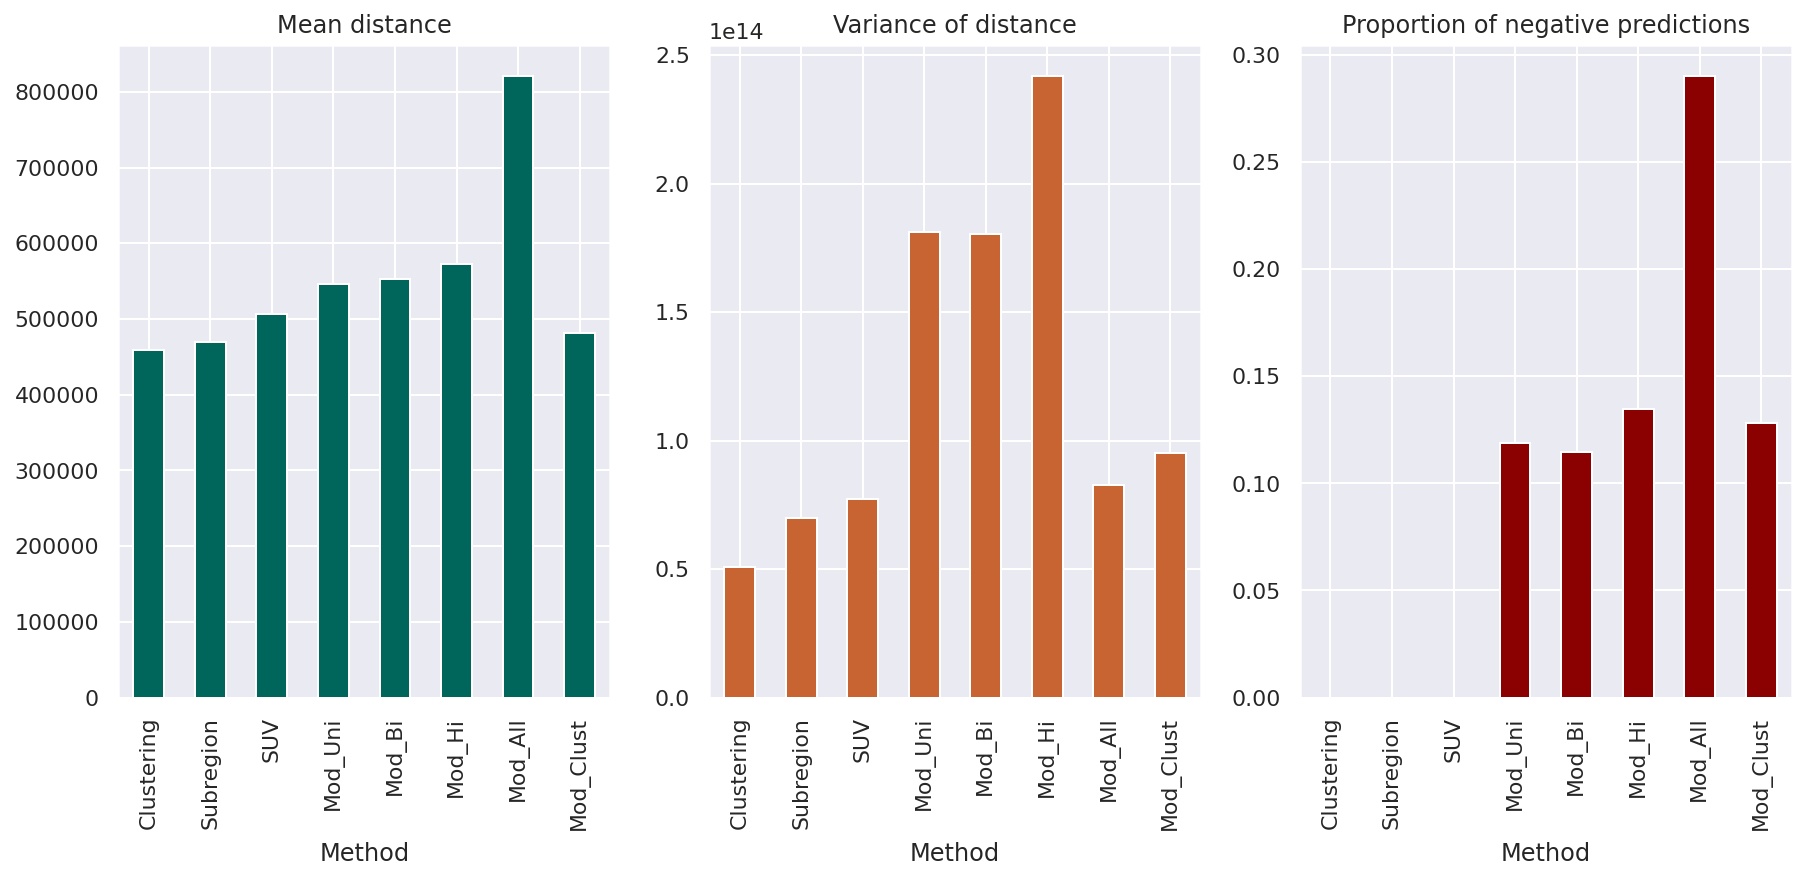

<AxesSubplot:title={'center':'Proportion of negative predictions'}, xlabel='Method'>

In [0]:
# calculate quantities according to clusters and subregions and get distance from reported quantities.
df_test['clustWgt'] = df_test['primaryValue']/df_test['clustUV']
df_test['subregWgt'] = df_test['primaryValue']/df_test['subregUV']
df_test['SUVWgt'] = df_test['primaryValue']/df_test['SUV']

df_test['clustDiff'] = abs(df_test[unit] - df_test['clustWgt'])
df_test['subregDiff'] = abs(df_test[unit] - df_test['subregWgt'])
df_test['SUVDiff'] = abs(df_test[unit] - df_test['SUVWgt'])
df_test['UniDiff'] = abs(df_test[unit] - df_test['fittedNetWeight_UNI'])
df_test['BiDiff'] = abs(df_test[unit] - df_test['fittedNetWeight_BI'])
df_test['HiDiff'] = abs(df_test[unit] - df_test['fittedNetWeight_HI'])
df_test['AllDiff'] = abs(df_test[unit] - df_test['fittedNetWeight_ALL'])
df_test['CustFitDiff'] = abs(df_test[unit] - df_test['fittedNetWeight_CLUST'])

#create a dataframe to compare mean and variance of distances from reported quantities
compare = pd.DataFrame({'Method':['Clustering', 'Subregion', 'SUV', 'Mod_Uni', 'Mod_Bi', 'Mod_Hi', 'Mod_All', 'Mod_Clust'],
                        'mean_distance':[df_test['clustDiff'].mean(), df_test['subregDiff'].mean(), df_test['SUVDiff'].mean(), df_test['UniDiff'].mean(), df_test['BiDiff'].mean(), df_test['HiDiff'].mean(), df_test['AllDiff'].mean(), df_test['CustFitDiff'].mean()],
                        'variance_distance':[df_test['clustDiff'].var(), df_test['subregDiff'].var(), df_test['SUVDiff'].var(), df_test['UniDiff'].var(), df_test['BiDiff'].var(), df_test['HiDiff'].var(), df_test['AllDiff'].var(), df_test['CustFitDiff'].var()],
                      'neg_val_prop':[(df_test['clustWgt']<0).sum()/len(df_test), (df_test['subregWgt']<0).sum()/len(df_test), (df_test['SUVWgt']<0).sum()/len(df_test), (df_test['fittedNetWeight_UNI']<0).sum()/len(df_test), (df_test['fittedNetWeight_BI']<0).sum()/len(df_test), (df_test['fittedNetWeight_HI']<0).sum()/len(df_test), (df_test['fittedNetWeight_ALL']<0).sum()/len(df_test), (df_test['fittedNetWeight_CLUST']<0).sum()/len(df_test)]})

#plot the mean distance and variance
fig = plt.figure()

# Divide the figure into a 1x3 grid, and give me the first section
ax1 = fig.add_subplot(131)
ax1.set_title("Mean distance")

# Divide the figure into a 1x3 grid, and give me the second section
ax2 = fig.add_subplot(132)
ax2.set_title("Variance of distance")

# Divide the figure into a 1x3 grid, and give me the third section
ax3 = fig.add_subplot(133)
ax3.set_title("Proportion of negative predictions")

compare.plot(kind='bar', x='Method', y='mean_distance', color='#00655b', legend=False, ax=ax1)
compare.plot(kind='bar', x='Method', y='variance_distance', color='#C86432', legend=False, ax=ax2)
compare.plot(kind='bar', x='Method', y='neg_val_prop', color='#8b0000', legend=False, ax=ax3)


In [0]:
display(df_test)

reporterCode partnerCode partner2Code period cmdCode cifValue fobValue primaryValue netWgt qtyUnitCode qty customsCode motCode unitValue commodity_group_code commodity_classification minUV maxUV SUV repCountryName repRegionName repSubRegionName repDevLevel partCountryName partRegionName partSubRegionName partDevLevel fittedNetWeight_UNI fittedNetWeight_BI fittedNetWeight_HI fittedNetWeight_ALL cluster fittedNetWeight_CLUST clustUV subregUV clustWgt subregWgt SUVWgt clustDiff subregDiff SUVDiff UniDiff BiDiff HiDiff AllDiff CustFitDiff 288 36 -1 2013 1006309000 727.0453880063999 727.0453880063999 727.0453880063999 530.71 8 530.71 -1 -1 1.3699485368777673 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Ghana Africa Sub-Saharan Africa Developing Australia Oceania Australia and New Zealand Developed 834.3135555240028 834.313524925922 67937.65171456677 -54109.50058981823 1 823.6400508683413 1.1390597063834977 1.0056695999999998 638.2855823376996 722.9465701323775 756.8514397047919 107.57558233769953 192.23657013237744 226.14143970479188 303.6035555240028 303.603524925922 67406.94171456677 54640.21058981823 292.93005086834125 634 36 -1 2013 10063000 135399.869270325 135399.869270325 135399.869270325 103910.0 8 103910.0 -1 -1 1.3030494588617554 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 155383.88029078254 155383.87459082186 179802.99170986837 -926353.3470922146 1 153388.59782179294 1.1390597063834977 1.0056695999999998 118869.86126497101 134636.53397728738 140950.7407427279 14959.861264971012 30726.533977287385 37040.74074272791 51473.880290782545 51473.874590821855 75892.99170986837 1030263.3470922146 49478.59782179294 634 36 -1 2013 10063000 257059.43579745 257059.43579745 257059.43579745 192643.0 8 192643.0 -1 -1 1.3343824369297093 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 295011.7279862298 295011.7171620151 281361.2888206402 -772704.029688131 1 291210.74020906846 1.1390597063834977 1.0056695999999998 225676.8757220031 255610.22804850622 267597.87942054716 33033.87572200311 62967.22804850622 74954.87942054716 102368.72798622982 102368.71716201509 88718.28882064018 965347.029688131 98567.74020906846 634 36 -1 2013 10063000 414676.20015855 414676.20015855 414676.20015855 301155.0 8 301155.0 -1 -1 1.3769527325083428 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 475924.62733393745 475924.6098671338 413644.82287655934 -573642.7561127087 1 469766.0861646612 1.1390597063834977 1.0056695999999998 364051.3292100749 412338.4063300214 431676.3221095467 62896.32921007491 111183.40633002139 130521.32210954669 174769.62733393745 174769.60986713378 112489.82287655934 874797.7561127087 168611.08616466122 634 36 -1 2013 10063000 272633.700168225 272633.700168225 272633.700168225 212215.0 8 212215.0 -1 -1 1.284705134737059 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 312887.0403409364 312887.02886055363 294396.7162982983 -753034.5934247132 1 308854.0131584283 1.1390597063834977 1.0056695999999998 239349.7888129447 271096.69037248916 283810.6284535695 27134.788812944695 58881.69037248916 71595.62845356949 100672.0403409364 100672.02886055363 82181.71629829833 965249.5934247132 96639.01315842831 634 36 -1 2013 10063000 143763.36777495 143763.36777495 143763.36777495 105672.0 8 105672.0 -1 -1 1.3604679363970587 100630 4 0.2105544350651834 4.086688939504 0.9606183589873096 Qatar Asia Western Asia Developing Australia Oceania Australia and New Zealand Developed 164982.2392528332 164982.23320068768 186769.36261906708 -915790.7101124157 1 162863.21434296938 1.1390597063834977 1.0056695999999998 126212.31966092202 142952.8

In [0]:
display(compare)

Method mean_distance variance_distance neg_val_prop Clustering 459604.6104531095 5.066303534097646E13 0.0 Subregion 470039.9881035959 6.999845448013492E13 0.0 SUV 506212.0061750276 7.728964809462436E13 0.0 Mod_Uni 545857.8309739601 1.8103324981110838E14 0.1190234974999183 Mod_Bi 552319.7565133155 1.8056359673053306E14 0.11487303506650544 Mod_Hi 572309.525741729 2.417987865121565E14 0.13464492303670056 Mod_All 820592.5776238652 8.285288390826748E13 0.2900094774339031 Mod_Clust 482112.83533801255 9.521236191444973E13 0.12804340011111473